In [1]:
# This code will attempt to replicate the Fama French Momentum Factor aka WML (Winners Minus Losers).
# The Methodology and Data has been taken from a number of papers including, most notably, 'Value, Size & Momentum in International Stock returns (2011)'.
# Some insights on the replication where taken from various podcasts in which either Professor Fama or Professor French were guests on.

In [2]:
import pandas as pd
import numpy as np
from scipy.stats import skew
from scipy.stats import kurtosis
import pyfolio as pf
import datetime as dt
from pandas.tseries.offsets import MonthEnd
from matplotlib import pyplot as plt
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 14)
pd.set_option('mode.chained_assignment', None)

c:\Users\Amal\anaconda3\Lib\site-packages\pyfolio\pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


# Data Wrangling and Preparation

# For Backtesting, Skip to Code Cell 18

In [3]:
data = pd.read_csv('/Users/Amal/Downloads/CRSP Returns Data All Exchanges 63-22.csv',low_memory=False)

In [4]:
formation = dt.datetime(1965,12,31)
formation_dates = []
for i in range(0,683):
    formation_dates.append(formation + MonthEnd(i))
returns_dates = []
for i in range(2,685):
    returns_dates.append(formation + MonthEnd(i))

In [5]:
data

,PERMNO,date,EXCHCD,TICKER,PRIMEXCH,RET
0,10000,07/01/1986,3,OMFGA,Q,C
1,10000,08/01/1986,3,OMFGA,Q,-0.024390
2,10000,09/01/1986,3,OMFGA,Q,0.000000
3,10000,10/01/1986,3,OMFGA,Q,0.000000
4,10000,13/01/1986,3,OMFGA,Q,0.050000
...,...,...,...,...,...,...
91828866,93436,23/12/2022,3,TSLA,Q,-0.017551
91828867,93436,27/12/2022,3,TSLA,Q,-0.114089
91828868,93436,28/12/2022,3,TSLA,Q,0.033089
91828869,93436,29/12/2022,3,TSLA,Q,0.080827


In [6]:
data = data.drop(['PRIMEXCH'],axis=1)
data = data.drop(['EXCHCD'],axis=1)

In [7]:
data.date = pd.to_datetime(data.date,dayfirst=True)

In [8]:
data = data[~data.duplicated(subset=['PERMNO', 'date'], keep='first')]

In [9]:
data1 = data.pivot(index='date', columns='PERMNO', values='RET')
data1.columns = [f"{col}" for col in data1.columns]
data1

,10000,10001,10002,10003,10004,10005,10006,...,93430,93431,93432,93433,93434,93435,93436
date,,,,,,,,,,,,,,,
1963-01-02,NaN,NaN,NaN,NaN,NaN,NaN,-0.001621,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1963-01-03,NaN,NaN,NaN,NaN,NaN,NaN,-0.006494,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1963-01-04,NaN,NaN,NaN,NaN,NaN,NaN,-0.006536,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1963-01-07,NaN,NaN,NaN,NaN,NaN,NaN,-0.006579,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1963-01-08,NaN,NaN,NaN,NaN,NaN,NaN,0.009934,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.043350,NaN,-0.017551
2022-12-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-0.014084,NaN,-0.114089
2022-12-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.035714,NaN,0.033089


In [10]:
filler = pd.DataFrame(data=range(len(formation_dates)),index=formation_dates)
data1 = data1.merge(filler,left_index=True,right_index=True,how='outer')
data1.drop([data1.columns[len(data1.columns)-1]],axis=1,inplace=True)
data1[data1.isna().all(axis=1)] = data1[data1.isna().all(axis=1)].fillna(0)

In [11]:
data1 = data1.apply(pd.to_numeric, errors='coerce')

In [12]:
# Calculating Monthly Returns
def calculate_yearly_return(group):
    non_nan_values = group.dropna()
    if len(non_nan_values) == 0:
        return np.nan
    return (non_nan_values + 1).prod() - 1


monthly_returns = data1.resample('M').apply(calculate_yearly_return)

In [13]:
monthly_returns

,10000,10001,10002,10003,10004,10005,10006,...,93430,93431,93432,93433,93434,93435,93436
1963-01-31,NaN,NaN,NaN,NaN,NaN,NaN,0.047003,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1963-02-28,NaN,NaN,NaN,NaN,NaN,NaN,0.038282,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1963-03-31,NaN,NaN,NaN,NaN,NaN,NaN,-0.009009,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1963-04-30,NaN,NaN,NaN,NaN,NaN,NaN,0.084848,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1963-05-31,NaN,NaN,NaN,NaN,NaN,NaN,0.091935,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.347369,NaN,-0.072489
2022-09-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-0.429688,NaN,-0.037591
2022-10-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.356165,NaN,-0.142169
2022-11-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.121210,NaN,-0.144327


In [14]:
past_10 = (monthly_returns+1).rolling(10).apply(np.prod)-1

In [15]:
Two_Year_Data_Check = data1.rolling(504,min_periods=410).std()

In [16]:
data_size = pd.read_csv('/Users/Amal/Downloads/CRSP Size Data All Exchanges 63-22.csv',low_memory=False)
data_size.date = pd.to_datetime(data_size.date,dayfirst=True)
data_size['Market Cap']= (data_size['PRC']/data_size['CFACPR'])*(data_size['SHROUT']*data_size['CFACSHR'])
data_size = data_size[~data_size.duplicated(subset=['PERMNO', 'date'], keep='first')]
Companies = data_size['PERMNO'].unique()
data_size1 = data_size.pivot(index='date', columns='PERMNO', values='Market Cap')
data_size1.columns = [f"{col}" for col in data_size1.columns]
data_size1 = data_size1.abs()
data_size1 = data_size1.apply(pd.to_numeric,errors='coerce')
data_size1

,10000,10001,10002,10003,10004,10005,10006,...,93430,93431,93432,93433,93434,93435,93436
date,,,,,,,,,,,,,,,
1963-01-02,NaN,NaN,NaN,NaN,NaN,NaN,111881.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1963-01-03,NaN,NaN,NaN,NaN,NaN,NaN,111154.50,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1963-01-04,NaN,NaN,NaN,NaN,NaN,NaN,110428.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1963-01-07,NaN,NaN,NaN,NaN,NaN,NaN,109701.50,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1963-01-08,NaN,NaN,NaN,NaN,NaN,NaN,110791.25,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,60524.66,NaN,3.888772e+08
2022-12-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,59672.20,NaN,3.445107e+08
2022-12-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,61803.35,NaN,3.559102e+08


In [17]:
monthly_size = data_size1.resample('M').last()
monthly_size = monthly_size*1000
monthly_size

,10000,10001,10002,10003,10004,10005,10006,...,93430,93431,93432,93433,93434,93435,93436
date,,,,,,,,,,,,,,,
1963-01-31,NaN,NaN,NaN,NaN,NaN,NaN,117329750.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1963-02-28,NaN,NaN,NaN,NaN,NaN,NaN,120962250.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1963-03-31,NaN,NaN,NaN,NaN,NaN,NaN,119872500.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1963-04-30,NaN,NaN,NaN,NaN,NaN,NaN,130043500.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1963-05-31,NaN,NaN,NaN,NaN,NaN,NaN,140941000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,54507520.0,NaN,8.636156e+11
2022-09-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,31103840.0,NaN,8.376595e+11
2022-10-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,42196770.0,NaN,7.185149e+11


# The Backtesting

In [18]:
formation = dt.datetime(1965,12,31)
formation_dates = []
for i in range(0,683):
    formation_dates.append(formation + MonthEnd(i))
returns_dates = []
for i in range(2,685):
    returns_dates.append(formation + MonthEnd(i))

# WML Replication

In [19]:
def WML_VW(formation,offset):

    sizelookback = pd.DataFrame(data = monthly_size.loc[formation])
    lookback = pd.DataFrame(data = past_10.loc[formation])
    Two_Year_Check = pd.DataFrame(data = Two_Year_Data_Check.loc[formation])
    
    merged = lookback.merge(sizelookback,left_index=True,right_index=True,how='inner')
    merged = merged.merge(Two_Year_Check,left_index=True,right_index=True,how='inner')
    merged = merged.dropna(axis=0)
    merged = merged.sort_values(by=merged.columns[2],ascending=False,na_position='last')
    merged.columns = ['Lookback Return','Size','Two Year Check']
    merged = merged[merged['Size']>1]

    Small = merged[round(len(merged)*0.5):]
    Large = merged[:round(len(merged)*0.5)]

    t = 10
    losers_target = [1,2,3]
    winners_target = [t,t-1,t-2]
    list1 = range(1,t+1)
    
    Large['MOM Allocation'] = pd.qcut(Large['Lookback Return'],t,list1)
    Large_Winners = Large[Large['MOM Allocation'].isin(winners_target)]
    Large_Losers = Large[Large['MOM Allocation'].isin(losers_target)]

    Small['MOM Allocation'] = pd.qcut(Small['Lookback Return'],t,list1)
    Small_Winners = Small[Small['MOM Allocation'].isin(winners_target)]
    Small_Losers = Small[Small['MOM Allocation'].isin(losers_target)]
    
    Large_Winners_Returns = monthly_returns.loc[formation + MonthEnd(offset),monthly_returns.columns.isin(Large_Winners.index)]
    Large_Losers_Returns = monthly_returns.loc[formation + MonthEnd(offset),monthly_returns.columns.isin(Large_Losers.index)]
    Small_Winners_Returns = monthly_returns.loc[formation + MonthEnd(offset),monthly_returns.columns.isin(Small_Winners.index)]
    Small_Losers_Returns = monthly_returns.loc[formation + MonthEnd(offset),monthly_returns.columns.isin(Small_Losers.index)]

    Large_Winners_Returns = pd.DataFrame(data=Large_Winners_Returns)
    Large_Losers_Returns = pd.DataFrame(data=Large_Losers_Returns)
    Small_Winners_Returns = pd.DataFrame(data=Small_Winners_Returns)
    Small_Losers_Returns = pd.DataFrame(data=Small_Losers_Returns)

    Large_Winners_Returns = Large_Winners_Returns.merge(sizelookback,left_index=True,right_index=True,how='inner')
    Large_Losers_Returns = Large_Losers_Returns.merge(sizelookback,left_index=True,right_index=True,how='inner')
    Small_Winners_Returns = Small_Winners_Returns.merge(sizelookback,left_index=True,right_index=True,how='inner')
    Small_Losers_Returns = Small_Losers_Returns.merge(sizelookback,left_index=True,right_index=True,how='inner')

    Large_Winners_Returns.dropna(inplace=True)
    Large_Losers_Returns.dropna(inplace=True)
    Small_Winners_Returns.dropna(inplace=True)
    Small_Losers_Returns.dropna(inplace=True)

    Large_Winners_Returns.iloc[:,1] = Large_Winners_Returns.iloc[:,1].values/sum(Large_Winners_Returns.iloc[:,1].values)
    Large_Losers_Returns.iloc[:,1] = Large_Losers_Returns.iloc[:,1].values/sum(Large_Losers_Returns.iloc[:,1].values)
    Small_Winners_Returns.iloc[:,1] = Small_Winners_Returns.iloc[:,1].values/sum(Small_Winners_Returns.iloc[:,1].values)
    Small_Losers_Returns.iloc[:,1] = Small_Losers_Returns.iloc[:,1].values/sum(Small_Losers_Returns.iloc[:,1].values)

    Large_Winners_RET = sum(Large_Winners_Returns[Large_Winners_Returns.columns[0]]*Large_Winners_Returns[Large_Winners_Returns.columns[1]])
    Large_Losers_RET = sum(Large_Losers_Returns[Large_Losers_Returns.columns[0]]*Large_Losers_Returns[Large_Losers_Returns.columns[1]])
    Small_Winners_RET = sum(Small_Winners_Returns[Small_Winners_Returns.columns[0]]*Small_Winners_Returns[Small_Winners_Returns.columns[1]])
    Small_Losers_RET = sum(Small_Losers_Returns[Small_Losers_Returns.columns[0]]*Small_Losers_Returns[Small_Losers_Returns.columns[1]])

    Large_Winners_Returns.dropna(inplace=True)
    Large_Losers_Returns.dropna(inplace=True)
    Small_Winners_Returns.dropna(inplace=True)
    Small_Losers_Returns.dropna(inplace=True)

    long = (Large_Winners_RET + Small_Winners_RET)/2
    short = (Large_Losers_RET + Small_Losers_RET)/2
    profit = long - short
    return profit

momentum = []
for i in formation_dates:
    momentum.append(WML_VW(i,2))
returns_dates = pd.to_datetime(returns_dates)
WML__VW = pd.DataFrame(data=momentum)
WML__VW['Dates']=returns_dates
WML__VW = WML__VW.set_index('Dates')
WML__VW = WML__VW[:580]
WML__VW.columns = ['Replication']

# Real WML Downloaded from Professor Ken French's Website

In [20]:
# WML sourced from Ken French's website
WML = pd.read_csv('/Users/Amal/Downloads/MOM FF.csv',index_col=0,header=0)
WML.index = pd.to_datetime(WML.index,format='%Y%m')
WML = WML.resample('M').last()
WML.columns = ['Real']
WML = WML[-683:1049]
WML = WML/100

# Replication/Real

In [21]:
# My Replication
Mean_Rep_WML = (WML__VW.mean()*12)*100
Vol_Rep_WML = (WML__VW.std()*(12**0.5))*100
print('Mean Return Replication WML:',round(Mean_Rep_WML.iloc[0],3),'%')
print('Vol Replication WML:',round(Vol_Rep_WML.iloc[0],3),'%')

Mean Return Replication WML: 8.037 %
Vol Replication WML: 15.246 %


In [22]:
# Real WML Factor from Ken French's Website
Mean_Real_WML = (WML.mean()*12)*100
Vol_Real_WML = (WML.std()*(12**0.5))*100
print('Mean Return Real WML:',round(Mean_Real_WML.iloc[0],3),'%')
print('Vol Real WML:',round(Vol_Real_WML.iloc[0],3),'%')

Mean Return Real WML: 8.094 %
Vol Real WML: 15.03 %


# Comparison

In [23]:
# Correlation between Fama French data and my attempted replication
combined = pd.concat([WML__VW,WML],axis=1)
print('Correlation Coefficent:',round(combined.corr().iloc[0,1],3))

Correlation Coefficent: 0.91


In [24]:
combined.columns = ['Replication','Real']
combined.head(8)

,Replication,Real
1966-02-28,0.050225,0.0457
1966-03-31,0.017038,0.0142
1966-04-30,0.028085,0.0628
1966-05-31,-0.035835,-0.0470
1966-06-30,0.042455,0.0325
1966-07-31,0.002905,-0.0134
1966-08-31,-0.005595,-0.0214
1966-09-30,-0.017496,-0.0184


# Drawdown Comparison Replication/Real

<Axes: title={'center': 'Underwater plot'}, ylabel='Drawdown'>

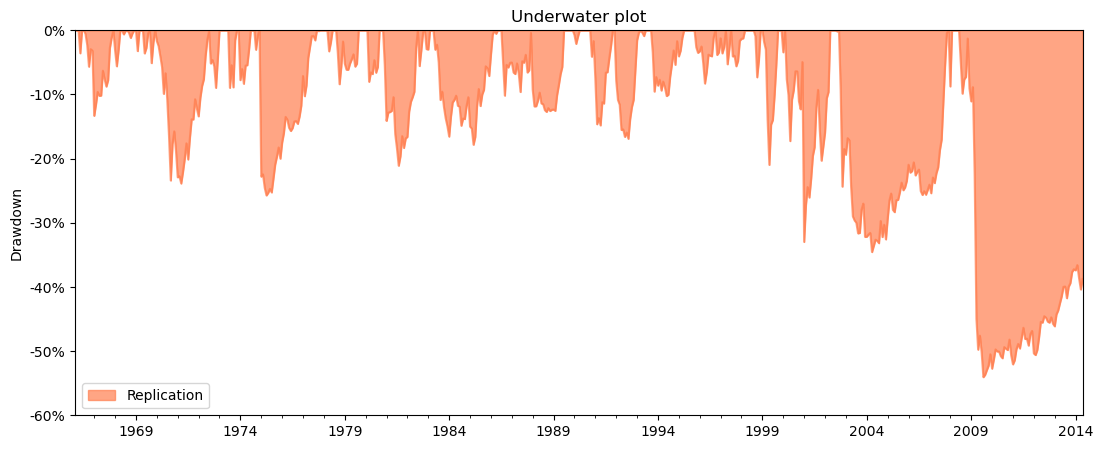

In [25]:
# Replication
fig = plt.figure(figsize=(13,5))
plt.ylim(-60,0)
pf.plot_drawdown_underwater(WML__VW)

<Axes: title={'center': 'Underwater plot'}, ylabel='Drawdown'>

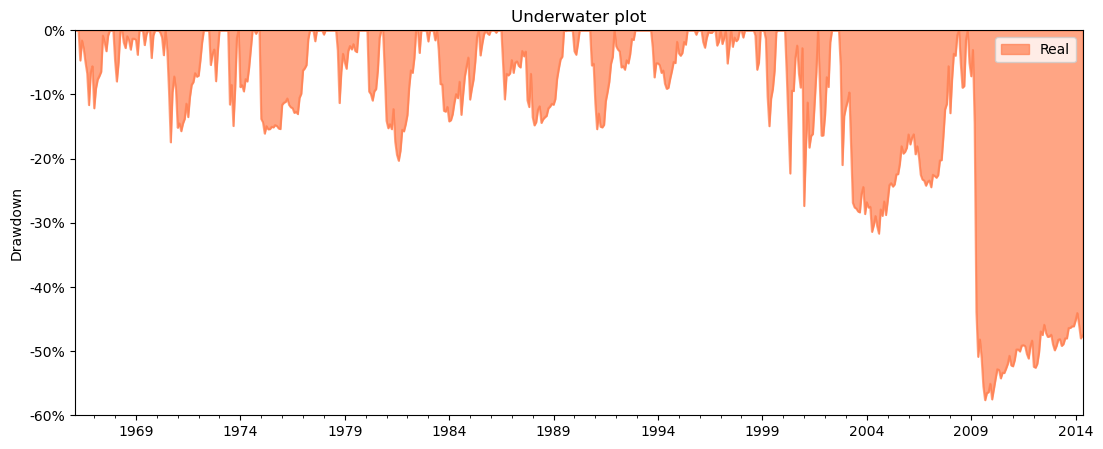

In [26]:
# Real
fig = plt.figure(figsize=(13,5))
plt.ylim(-60,0)
pf.plot_drawdown_underwater(WML)

# Equity Curves Plotted

<function matplotlib.pyplot.show(close=None, block=None)>

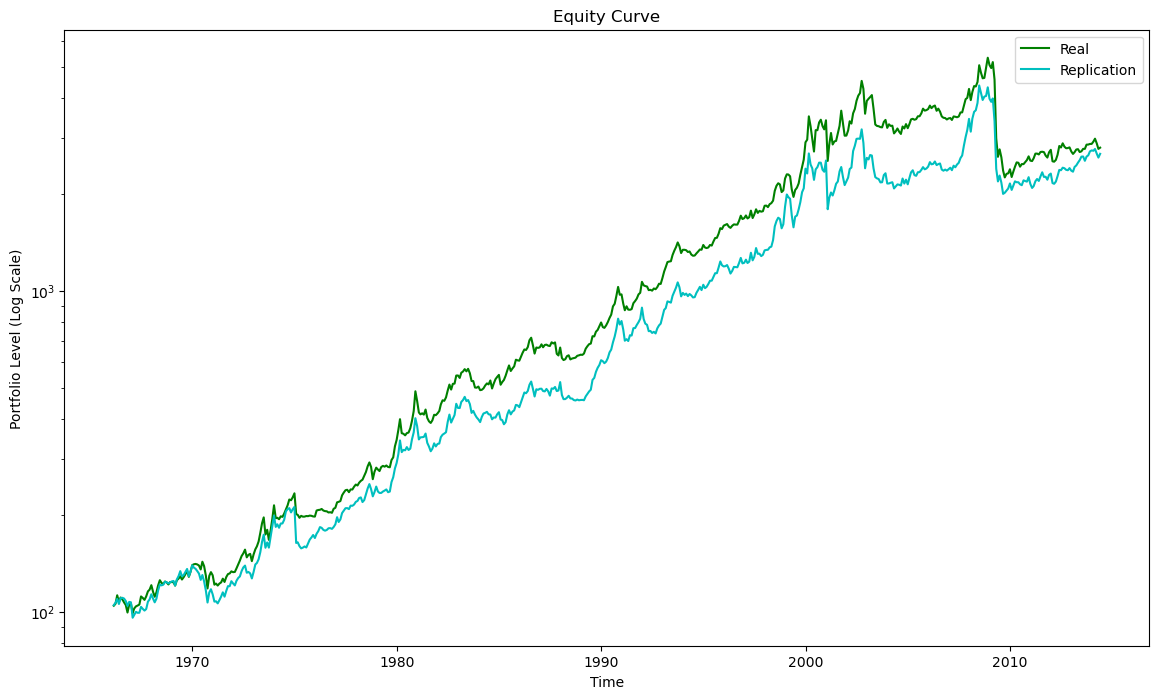

In [27]:
fig = plt.figure(figsize=(14,8))
plt.plot(WML.index,100*(WML+1).cumprod(),label='Real',color='g')
plt.plot(WML__VW.index,100*((WML__VW+1)).cumprod(),label='Replication',color='c')
plt.legend()
plt.yscale('log')
plt.xlabel('Time')
plt.ylabel('Portfolio Level (Log Scale)')
plt.title('Equity Curve')
plt.show